# ALGORITMO KNN:

El algoritmo KNN es más robusto para la regresión que la regresion lineal pues devuelve los k vecinos más cercanos de ground truth.

In [1]:
import numpy as np
from math import sqrt
from sklearn import datasets, linear_model, metrics
from pprint import pprint
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split, KFold
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga de datos.
dataset = datasets.fetch_california_housing()
X = dataset.data
y = dataset.target
print(np.shape(X))

(20640, 8)


In [3]:
# Métricas de evaluación.
metricas = {'MAE':  'neg_mean_absolute_error',
            'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(metrics.mean_squared_error(y, y_pred)),
                      greater_is_better=False),
            'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False),
                      
            'R2':'r2'}

### 1) PARTICIÓN EXTERNA DE DATOS

In [4]:
# 1) Partición de datos externa
X_training, X_testing, y_training, y_testing = train_test_split(X, y, test_size=0.2, random_state=42) # primero x y luego y
print(np.shape(X_training))
print(np.shape(X_testing))

(16512, 8)
(4128, 8)


### 2-5) ENTRENAMIENTO

In [5]:
# 2) Extracción de características
# 3) Selección de atributos

In [6]:
# 4) Estandarización de los datos de entrenamiento
standardizer = preprocessing.StandardScaler()
X_stdr = standardizer.fit_transform(X_training)

In [7]:
# 5) Construcción del algoritmo de aprendizaje.
k = 10
reg = KNeighborsRegressor(n_neighbors = k, weights='distance', metric='euclidean')

In [8]:
# 5.1) Validación cruzada interna

# Extraer MEAN +- STD del coeficiente de determinación (R2) para un cross validation de 5 bolsas aleatorias y semilla en 42
r2_cv_results = cross_validate(reg, X_stdr, y_training, 
                                    cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)
#print(r2_cv_results.keys())
print("cross_val_R2:   %0.4f +/- %0.4f" % (r2_cv_results['test_R2'].mean(), r2_cv_results['test_R2'].std()))

cross_val_R2:   0.6962 +/- 0.0096


In [9]:
# Extraer métricas MAE, MSE, RMSE y MAPE en un cross validation para 5 bolsas aleatorias y semilla en 42
metrics_cv_results = cross_validate(reg, X_stdr, y_training, 
                                    cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring=metricas)
pprint(metrics_cv_results)

{'fit_time': array([0.01595759, 0.0279274 , 0.01396108, 0.01496458, 0.01396227]),
 'score_time': array([0.27538419, 0.25902057, 0.25538588, 0.25290751, 0.26187634]),
 'test_MAE': array([-0.45508636, -0.43747382, -0.42656226, -0.43984405, -0.43381931]),
 'test_MAPE': array([-24.61909207, -23.96339877, -23.97232907, -24.28066021,
       -23.49003617]),
 'test_R2': array([0.69060555, 0.69611085, 0.71414633, 0.68628936, 0.69379863]),
 'test_RMSE': array([-0.65342222, -0.63534593, -0.61742286, -0.65008873, -0.62943728])}


In [10]:
# Extraer las predicciones del cross validation de 5 bolsas aleatorias y semilla en 42

y_pred = cross_val_predict(reg, X_stdr, y_training, cv= KFold(5, shuffle= True, random_state= 42))

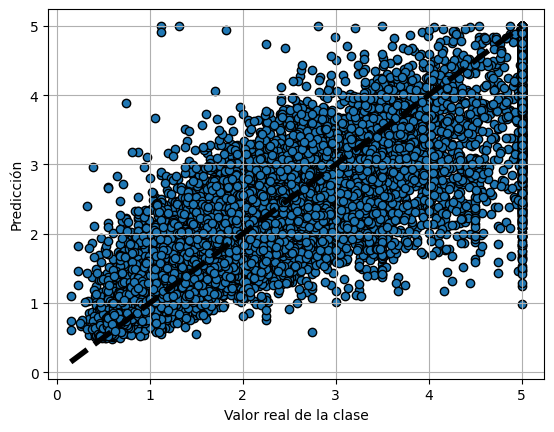

In [11]:
# Crear una función que dadas las variables "y" e "y_pred" se visualice la bisectriz
def plot_bisectriz(y, y_pred):
    fig, ax = plt.subplots()
    ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.grid()
    plt.show()

# Visualiza la bisetriz
plot_bisectriz(y_training, y_pred)

In [12]:
# 5.2) Entrenamiento del modelo definitivo
model = reg.fit(X_stdr, y_training)

### 6-10) PREDICCIÓN

In [13]:
# 6) Extracción de las características de test
# 7) Selección de los atributos de test 

In [14]:
# 8) Estandarización de las característiacs de test
X_test_stdr = standardizer.transform(X_testing)

In [15]:
# 9) Predicción del conjunto de test
y_pred_test = model.predict(X_test_stdr)

MAE:  0.4368
MSE: 0.4163
RMSE: 0.6452
R2:   0.6823


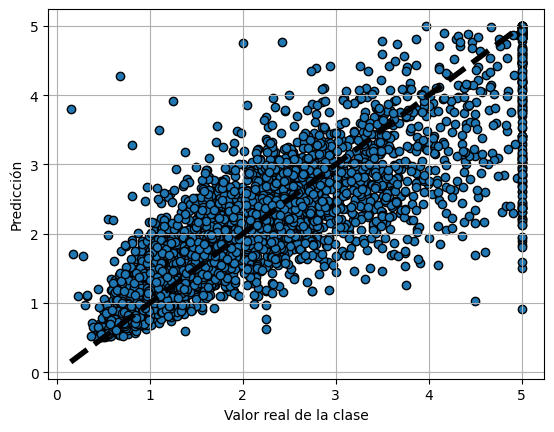

In [16]:
# 10) Evaluación del modelo sobre el conjunto de test
MAE = metrics.mean_absolute_error(y_testing, y_pred_test)
MSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=True)
RMSE = metrics.mean_squared_error(y_testing, y_pred_test, squared=False)
R2 = metrics.r2_score(y_testing, y_pred_test)

print('MAE:  %.4f' % MAE)
print('MSE: %.4f' % MSE)
print('RMSE: %.4f' % RMSE)
print('R2:   %.4f' % R2)

# Visualización de resultados
plot_bisectriz(y_testing, y_pred_test)

### ACTIVIDAD EXTRA

#### Entrenar el mejor modelo posible con el algoritmo KNN y comparar el resultado con el modelo OLS en test

In [17]:
from sklearn.model_selection import GridSearchCV
# Definir parámetros de búsqueda
parameters = {'n_neighbors' :range(5,15), 'weights': ('uniform', 'distance')}

# Aplicar el algoritmo de búsqueda
knn_reg = KNeighborsRegressor()
model= GridSearchCV(knn_reg, parameters, scoring='r2')

# Entrenar el modelo
model.fit(X_stdr, y_training)

# Extraer los mejores parámetros

print(model.best_params_)

{'n_neighbors': 11, 'weights': 'distance'}


In [18]:
# Entrenar cada algoritmo y comparar los resultados (a nivel cuantitativo y cualitativo) sobre el conjunto de test
best_KNN_model = model.best_estimator_
print(model.best_score_)

0.6962691955659895


In [27]:
y_pred_test = best_KNN_model.predict(X_test_stdr)

metricas = {
  'MAE' : lambda y, y_pred: metrics.mean_absolute_error(y, y_pred),
  'RMSE': lambda y, y_pred: sqrt(metrics.mean_squared_error(y, y_pred)),
  'MAPE': lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100,
  'R2'  : lambda y, y_pred: metrics.r2_score(y, y_pred)}


for nombre, metrica in metricas.items():
    print(f'para la metrica \t {nombre} \t  se obtienen un valor de \t  ---> \t {metrica(y_testing, y_pred_test)}')

para la metrica 	 MAE 	  se obtienen un valor de 	  ---> 	 0.4350962840243672
para la metrica 	 RMSE 	  se obtienen un valor de 	  ---> 	 0.6431147029750164
para la metrica 	 MAPE 	  se obtienen un valor de 	  ---> 	 24.24378538515978
para la metrica 	 R2 	  se obtienen un valor de 	  ---> 	 0.6843760016526612


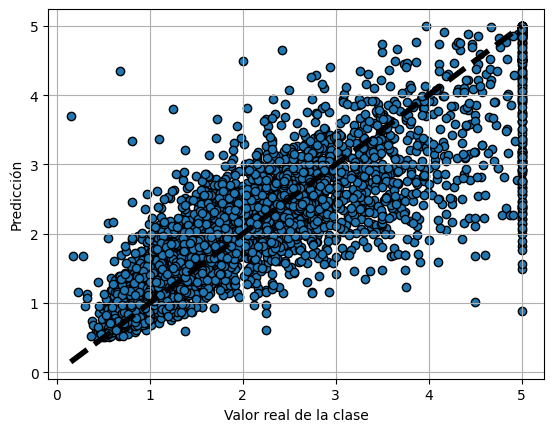

In [20]:
plot_bisectriz(y_testing, y_pred_test)

In [26]:
print(f'El r2 score para el test con el algorimto KNN es: {round(metrics.r2_score(y_testing, y_pred_test), 2)}')

El r2 score para el test con el algorimto KNN es: 0.68


In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
lin_reg = LinearRegression(fit_intercept= True)

cross_val_results = cross_validate(estimator=lin_reg,                                              # el modelo
                                   X= X_stdr,                                                  # las features escaladas
                                   y= y_training,                                              # las respuestas
                                   cv = KFold(n_splits=5, shuffle=True, random_state=42),      # los parametros del cross validation
                                   scoring=metricas)                                           # que scores o métricas queremos que guarde

#print("cross_val_MAE:   %0.4f +/- %0.4f" % (-cross_val_results.mean(), cross_val_results.std()))
# print(type(cross_val_results))
# print(cross_val_results.keys())

for metrica, resultados in cross_val_results.items():
    print('Para la métrica:\t{} \t se han obtenido de media los siguientes resultados \t ---> \t{}'.format(metrica, round(resultados.mean(), 4)))

Para la métrica:	fit_time 	 se han obtenido de media los siguientes resultados 	 ---> 	0.0045
Para la métrica:	score_time 	 se han obtenido de media los siguientes resultados 	 ---> 	0.0031
Para la métrica:	test_MAE 	 se han obtenido de media los siguientes resultados 	 ---> 	nan
Para la métrica:	test_RMSE 	 se han obtenido de media los siguientes resultados 	 ---> 	nan
Para la métrica:	test_MAPE 	 se han obtenido de media los siguientes resultados 	 ---> 	nan
Para la métrica:	test_R2 	 se han obtenido de media los siguientes resultados 	 ---> 	nan


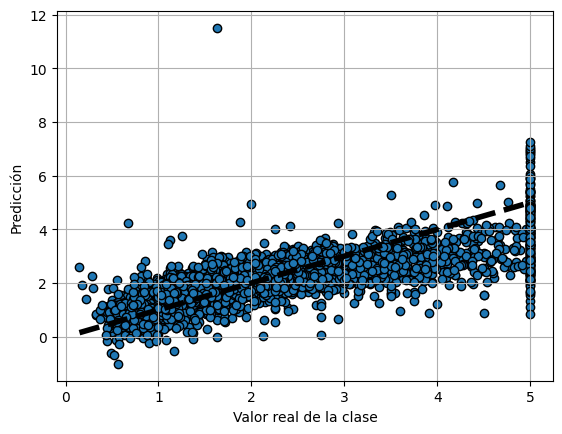

In [24]:
lin_reg.fit(X_stdr, y_training)
y_pred_test_ols = lin_reg.predict(X_test_stdr)
plot_bisectriz(y_testing, y_pred_test_ols)

In [25]:
print(f'La r2 score de la regresion lineal simple es de {round(metrics.r2_score(y_testing, y_pred_test_ols), 4)}')

La r2 score de la regresion lineal simple es de 0.5758
